## Importing relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, spearmanr

In [2]:
col_eq = 'Frings et al. (2011)  [Estimated kf]'
equation = 'frings'

## Data reading and handling

In [3]:
# Read all data tables
df_slurp = pd.read_csv('data/merged_kf_sr.csv')
df_ido = pd.read_excel('data/idoc-all-new.xlsx', engine='openpyxl')
df_hydro = pd.read_excel('data/hydro-multipacpoints-depth.xlsx', engine='openpyxl', skiprows=[1])
df_ido = df_ido.rename(columns={'meas_station':'sample'})
df_vhg = pd.read_csv('data/vhg-meas.csv')

# Perform the merge on 'sample' and rounded 'depth'
df_slurp_ido = pd.merge(df_slurp, df_ido, on=['sample', 'dp_position'], how='outer', suffixes=('_slurp', '_ido'))
df_slurp_ido['depth_rounded'] = df_slurp_ido['depth_sat_zone_slurp'].round(3).astype(float)
df_hydro['depth_rounded'] = df_hydro['Sediment depth kf'].round(3).astype(float)

df = pd.merge(df_slurp_ido, df_hydro, on=['sample', 'depth_rounded'], how='outer')
df = pd.merge (df, df_vhg, on =['sample'], how='outer')
df = df.dropna(subset=['depth_sat_zone_ido'])

C:\Users\Negreiros\AppData\Local\Temp\ipykernel_15476\2995027242.py:9: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_slurp_ido = pd.merge(df_slurp, df_ido, on=['sample', 'dp_position'], how='outer', suffixes=('_slurp', '_ido'))


In [13]:
df[['SNR1', 'SNR2', 'SNR3']].min().min()

30.021

In [10]:
df[['SNR1', 'SNR2', 'SNR3']].max().max()

59.202

Make disconnectivit metrics absolute values expressing differences between surface and porwater

In [4]:
df['delta_IDO_norm'] = df['delta_IDO_norm'].abs()
df['delta_T_norm'] = df['delta_T_norm'].abs()
df['sample'].unique()

array(['A-1', 'A-2', 'A-3', 'A-4', 'A-SW', 'B-1', 'B-2', 'B-3', 'B-4',
       'B-SW', 'C-1', 'C-2', 'C-3', 'C-4', 'C-SW', 'D-1', 'D-2', 'D-3',
       'D-4', 'D-SW', 'E-1', 'E-2', 'E-3', 'E-4', 'E-SW', 'F-1', 'F-2',
       'F-3', 'F-4', 'F-SW', 'G-1', 'G-2', 'G-3', 'G-4', 'G-SW', 'H-1',
       'H-2', 'H-3', 'H-4', 'H-SW'], dtype=object)

## Computing vertical hyporheic flow proxies (VHF)

In [5]:
#df['he'] = df['vhg']*df['Frings et al. (2011)  [Estimated kf]']
df['vc'] = df['vhg']*df[col_eq]
df['vc_abs'] = df['vc'].abs()
df['VelZ_abs'] = df['VelZ'].abs()
df['VelX_abs'] = df['VelX'].abs()
df['VelY_abs'] = df['VelY'].abs()

In [6]:
for col in df.columns:
    print(col)

Unnamed: 0
Unnamed: 0_slurp
sample
Profile ID
profile_location
samp_method
date_slurp
lat_slurp_x
lon_slurp
d10_x
d16_x
d25_x
d30_x
d50_x
d60_x
d75_x
d84_x
d90_x
Mean Grain Size dm [mm]_x
Geometrical mean dg [mm]_x
Sorting Index 1 ds_x
Fredle - Index_x
Grain Size std_x
Geometric Standard Deviation_x
Skewness_x
Kurtosis_x
Coefficient of uniformity - Cu_x
Curvature coefficient - Cc_x
Carling and Reader (1982) [Porosity]_x
Wu and Wang (2006) [Porosity]_x
Wooster et al. (2008) [Porosity]_x
Frings et al. (2011)  [Porosity]_x
User input [Porosity]
Carling and Reader (1982) [Estimated kf]
Wu and Wang (2006) [Estimated kf]
Wooster et al. (2008) [Estimated kf]_slurp
Frings et al. (2011)  [Estimated kf]
User input [Estimated kf]
250
125
63
31.5
16
8
4
2
1
0.5
0.25
0.125
0.063
0.031
0.0039
6.00E-05
dp_position
H_m_slurp
depth_slurp
comment_slurp
slurp_rate1
slurp_rate2
slurp_rate3
slurp_rate4
slurp_rate_final
wl
wl_stick
z_bed
z_watersurface
lz
operator
Unnamed: 0_kf
site_name_slurp
depth_kf
dept

Now we need to rename the variables to something readable and meaningful

In [7]:
# Define features and target variable
variables = [
            'depth_sat_zone_ido', 
            'wl',
            'log_kf_equation',
            'slurp_rate_final',
            'delta_IDO_norm',
            'delta_T_norm',
            #'delta_T_norm',
            'Vhoriz',
            'vtot', 
            'VelZ', 
            'VelZ_abs',
            #'VelX',
            #'VelX_abs',
            #'VelY',
            #'VelY_abs',
            'd50_x',
            '2',
            'vhg',
            'vc',
            'vc_abs',
            'site',
            'sample'
        	]
equation = 'frings'
df['log_kf_equation'] = np.log10(df['Frings et al. (2011)  [Estimated kf]'])

mapper = {'depth_sat_zone_ido': '$h_z$', 
            'wl': '$h$',
            'log_kf_equation': '$log(k_{f,Kozeny})$',
            'slurp_rate_final': '$s_r$',
            'delta_IDO_norm': '$\Delta DO_{norm}$',
            'delta_T_norm': '$\Delta T_{norm}$',
            #'delta_T_norm',
            'Vhoriz': '$v_{2d}$',
            'vtot': '$v_{3d}$', 
            'VelZ': '$w$', 
            'VelZ_abs': '$|w|$',
            #'VelX': '$u$',
            #'VelX_abs': '$|u|$',
            #'VelY': '$v$',
            #'VelY_abs': '$|v|$',
            'd50_x': '$d_{50}$',
            '2': '$FSF_{<2}$',
             'vhg': '$VHG$',
             'vc': '$VHF$',
             'vc_abs': '$|VHF|$'}
df = df.dropna(subset=variables)

C:\lkl\negreiros\Anaconda3\envs\py39_new\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
df[['sample', 'vhg', 'vc', '0.063', col_eq]].drop_duplicates()

,sample,vhg,vc,0.063,Frings et al. (2011) [Estimated kf]
27,A-3,-0.02,-1.258000e-06,1.292247,0.000063
64,B-3,0.10,4.570000e-06,1.122334,0.000046
75,B-4,0.09,9.371880e-06,0.712946,0.000104
102,C-3,-0.07,-3.206000e-06,1.164083,0.000046
111,C-4,-0.03,-1.329000e-06,0.819672,0.000044
141,D-3,0.08,1.384000e-06,0.468384,0.000017
154,D-4,0.02,4.320000e-07,0.376344,0.000022
180,E-3,0.20,2.080000e-06,1.229105,0.000010
190,E-4,0.10,2.620000e-07,2.149321,0.000003
256,G-3,0.00,0.000000e+00,0.540424,0.000016


In [116]:
# Calculate correlation matrix
df_renamed = df[variables].rename(columns=mapper)
grouped_averages = df_renamed.groupby(['site', 'sample']).mean().reset_index()
df_2corr_avg = grouped_averages.drop(columns=['site', 'sample', '$h_z$'])
corr_matrix = df_2corr_avg.corr(method='spearman')

## Kurskal-Wallis test to check differences in VHF between sites

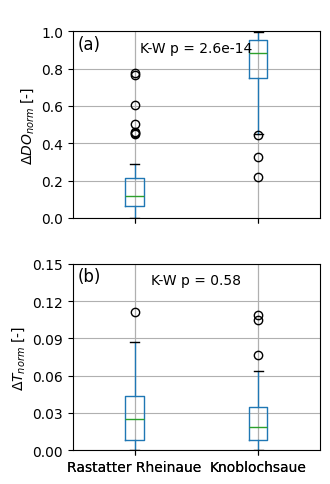

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from matplotlib.ticker import ScalarFormatter

# 1. Rename sites
df['site_renamed'] = df['site'].map({
    'RR': 'Rastatter Rheinaue',
    'KN': 'Knoblochsaue'
})

# 2. Declare categorical with the exact order you want
df['site_renamed'] = pd.Categorical(
    df['site_renamed'],
    categories=['Rastatter Rheinaue', 'Knoblochsaue'],
    ordered=True
)

# 3a. Kruskal–Wallis for ΔDO_norm
rr_do  = df[df['site']=='RR']['delta_IDO_norm']
kn_do  = df[df['site']=='KN']['delta_IDO_norm']
stat_do, p_do = kruskal(rr_do, kn_do)

# 3b. Kruskal–Wallis for |ΔT_norm|
rr_t   = df[df['site']=='RR']['delta_T_norm']
kn_t   = df[df['site']=='KN']['delta_T_norm']
stat_t, p_t = kruskal(rr_t, kn_t)

# 4. Create figure with two subplots
fig, axes = plt.subplots(nrows=2, figsize=(4*0.85, 6*0.85), sharex=True)

# 5. First panel: ΔDO_norm by site
df.boxplot(
    column='delta_IDO_norm',
    by='site_renamed',
    grid=False,
    ax=axes[0]
)
axes[0].set_title(' ')
axes[0].set_xlabel('')
axes[0].set_ylabel('$\\Delta DO_{norm}$ [-]')
axes[0].set_ylim(0, 1)
axes[0].text(
    0.5, 0.95,
    f'K-W p = {p_do:.1e}',
    transform=axes[0].transAxes,
    ha='center',
    va='top'
)
axes[0].text(
    0.02, 0.98,
    '(a)',
    transform=axes[0].transAxes,
    ha='left',
    va='top',
    fontsize=12,
    #fontweight='bold'
)
axes[0].yaxis.set_major_formatter(ScalarFormatter())
axes[0].grid(True)

# 6. Second panel: |ΔT_norm| by site
df.boxplot(
    column='delta_T_norm',
    by='site_renamed',
    grid=False,
    ax=axes[1]
)
axes[1].set_title(' ')
axes[1].set_xlabel('')
axes[1].set_ylabel('$\\Delta T_{norm}$ [-]')
axes[1].set_ylim(0, 0.15)
axes[1].set_yticks(np.arange(0, 0.16, 0.15/5))
axes[1].text(
    0.5, 0.95,
    f'K-W p = {p_t:.2f}',
    transform=axes[1].transAxes,
    ha='center',
    va='top'
)
axes[1].text(
    0.02, 0.98,
    '(b)',
    transform=axes[1].transAxes,
    ha='left',
    va='top',
    fontsize=12,
    #fontweight='bold'
)
axes[1].yaxis.set_major_formatter(ScalarFormatter())
axes[1].grid(True)

# 7. Final layout, save, show
plt.suptitle('')
plt.tight_layout()
plt.savefig('figs/dissim-metrics-positions3-4.png.png', dpi=600)
plt.show()

In [118]:
rr_t.shape

(36,)

In [119]:
kn_t.shape

(56,)

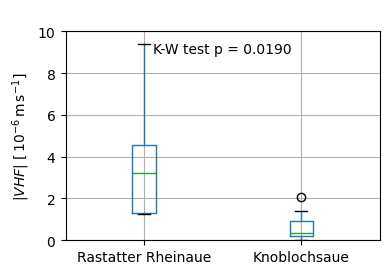

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from matplotlib.ticker import ScalarFormatter

# 1. Rename sites
grouped_averages['site_renamed'] = grouped_averages['site'].map({
    'RR': 'Rastatter Rheinaue',
    'KN': 'Knoblochsaue'
})

# 2. Declare categorical with the exact order you want
grouped_averages['site_renamed'] = pd.Categorical(
    grouped_averages['site_renamed'],
    categories=['Rastatter Rheinaue', 'Knoblochsaue'],
    ordered=True
)

# 3. Kruskal–Wallis Test
rr = grouped_averages[grouped_averages['site']=='RR']['$|VHF|$']
kn = grouped_averages[grouped_averages['site']=='KN']['$|VHF|$']
stat, p_value = kruskal(rr, kn)

# 4. Plot
fig, ax = plt.subplots(figsize=(4, 3))
grouped_averages.boxplot(
    column='$|VHF|$',
    by='site_renamed',
    grid=False,
    ax=ax
)

ax.set_title(' ')
ax.set_xlabel('')

# 5. Force scientific y-axis at 10⁻⁶
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(-6, -6))

# 6. Embed offset into the label
offset = ax.yaxis.get_offset_text().get_text()
ax.yaxis.get_offset_text().set_visible(False)
ax.set_ylabel(
    r'$|VHF|\ [\,10^{-6}\,\mathrm{m}\,\mathrm{s}^{-1}]$'
)

# 7. Final touches
ax.set_ylim(0, 10e-6)
ax.text(0.5, 0.95, f'K-W test p = {p_value:.4f}',
        transform=ax.transAxes, ha='center', va='top')
plt.suptitle('')
plt.grid(True)
plt.tight_layout()
plt.savefig('figs/vhf-sites.png', dpi=600)
plt.show()


In [121]:
# param1 = ['$log(k_{f,Kozeny})$', '$log(k_{f,Kozeny})$']
# param2 = ['$VHF$', '$VHG$']

pairwise_params2mask = [('$log(k_{f,Kozeny})$', '$VHF$'), 
                        ('$log(k_{f,Kozeny})$', '$|VHF|$'),
                        ('$log(k_{f,Kozeny})$', '$d_{50}$'),
                        ('$log(k_{f,Kozeny})$', '$FSF_{<2}$'),
                        ('$VHG$', '$VHF$'),
                        ('$v_{2d}$', '$v_{3d}$'),
                        ('$v_{3d}$', '$w$'),
                        ('$v_{3d}$', '$|w|$'),
                        ('$w$', '$|w|$')
                       ]

# Initialize mask to hide upper triangle (excluding diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)

for pairwise_param2mask_pair in pairwise_params2mask:
    # find their integer positions
    ii = list(corr_matrix.columns).index(pairwise_param2mask_pair[0])
    jj = list(corr_matrix.columns).index(pairwise_param2mask_pair[1])
    # mask both [i, j] and [j, i]
    mask[ii, jj] = True
    mask[jj, ii] = True

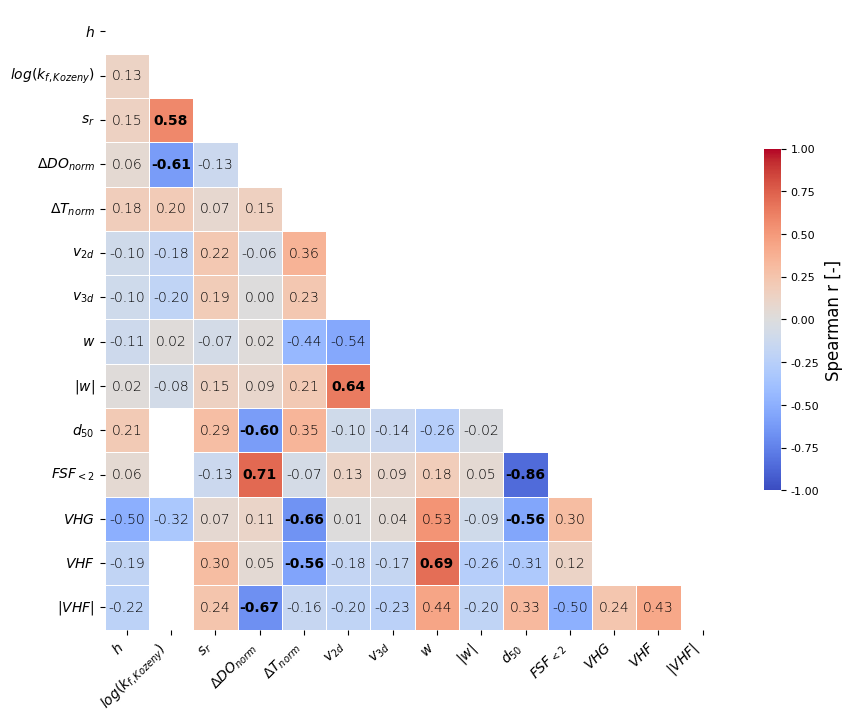

In [122]:
# compute the overall min and max
vmin = corr_matrix.values.min()
vmax = corr_matrix.values.max()

plt.figure(figsize=(9, 9))
ax = sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=True,
    mask=mask,
    linewidths=0.5,
    vmin=-1,
    vmax=1,
    cbar_kws={
        "shrink": 0.4
    }
)

cbar = ax.collections[0].colorbar
cbar.set_label("Spearman r [-]", fontsize=12)
cbar.ax.tick_params(labelsize=8)

# force ticks at the extremes
ticks = np.arange(1, -1.1, -0.25)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.2f}" for t in ticks])

cols = corr_matrix.columns

pvals = pd.DataFrame(np.ones((len(cols), len(cols))), index=cols, columns=cols)
for i, ci in enumerate(cols):
    for j, cj in enumerate(cols):
        if i < j:
            r, p = spearmanr(df_2corr_avg[ci], df_2corr_avg[cj])
            pvals.iloc[i, j] = pvals.iloc[j, i] = p
            
n = len(cols)
for i in range(n):
    for j in range(n):
        if mask[i, j]:
            continue
        r_val = corr_matrix.iloc[i, j]
        p_val = pvals.iloc[i, j]
        txt = f"{r_val:.2f}"
        weight = 'heavy' if p_val < 0.05 else 'ultralight'
        ax.text(
            j + 0.5,
            i + 0.5,
            txt,
            ha='center',
            va='center',
            fontsize=10,
            fontweight=weight,
            color='black'
        )

ax.set_xticklabels(cols, rotation=45, ha='right')
ax.set_yticklabels(cols, rotation=0)
#ax.set_title("Spearman Correlations\n(bold = p < 0.05)")

plt.tight_layout()
plt.savefig("figs/corr-matrix-positions3-4.png".format(equation), dpi=600, bbox_inches='tight')

In [123]:
df_renamed['Site'] = df_renamed['site'].map({
    'RR': 'Rastatter Rheinaue',
    'KN': 'Knoblochsaue'
})

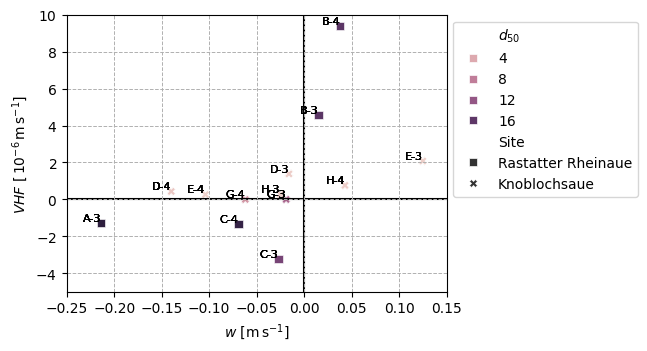

In [124]:
markers = {"Rastatter Rheinaue": "s", "Knoblochsaue": "X"}

fig, ax = plt.subplots(figsize=(7*0.7, 6*0.6))

ax = sns.scatterplot(data=df_renamed, x='$w$', y='$VHF$', hue='$d_{50}$', style='Site',markers=markers)
# Set y-axis to log scale
#ax.set_yscale('log')

# Set custom axis lines at x=0 and y=0 (with lower zorder)
ax.axhline(0, color='black', linewidth=1.5, linestyle='-', zorder=1, markersize=8)  # y=0
ax.axvline(0, color='black', linewidth=1.5, linestyle='-', zorder=1, markersize=8)  # x=0

#ax.set_xlabel('w [m s]')

ax.set_xlabel(
    r'$w\ [\mathrm{m}\,\mathrm{s}^{-1}]$'
)

# 5. Force scientific y-axis at 10⁻⁶
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(-6, -6))

# 6. Embed offset into the label
offset = ax.yaxis.get_offset_text().get_text()
ax.yaxis.get_offset_text().set_visible(False)
ax.set_ylabel(
    r'$VHF\ [\,10^{-6}\,\mathrm{m}\,\mathrm{s}^{-1}]$'
)

# 7. Final touches
ax.set_ylim(-5e-6, 10e-6)

# Add text labels for each sample
for _, row in df_renamed.iterrows():
    ax.text(row['$w$'], row['$VHF$'], row['sample'], fontsize=8, ha='right', va='bottom')

#ax.set_ylim(bottom=-0.5*10**(-5), top=1.5*10**(-5))
ax.set_xlim(left=-0.25, right=0.15)

# Add grid with proper visibility
plt.grid(True, which="both", linestyle='--', linewidth=0.7)

# Move the legend to a desired location
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

fig.savefig("figs/HE-vs-w-{0}.png".format(equation), dpi=600, bbox_inches='tight')